En este código se busca comparar el método de Chorin con IPCS.

In [1]:
# importar gmsh

%%capture
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [2]:
# importar dolfinx

%%capture
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [3]:
# instalar e importar pyvista

!pip install pyvista
import pyvista as pv

In [4]:
!pip install PyVirtualDisplay

In [5]:
from dolfinx import  default_scalar_type

In [6]:
import pyvista as pv
from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

True

In [7]:
# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

# imageio
import imageio

In [8]:
# comm
comm = MPI.COMM_WORLD

Se utilizará como dominio un rectángulo con un obstáculo esférico en su interior y un mallado refinado tras la esfera.

In [9]:
def create_dom2d_ball(length=3, height=1):
    gmsh.initialize()
    gmsh.model.add("rect")

    # Crear el rectángulo
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, length, height)

    # Crear el disco (círculo en 2D)
    disk = gmsh.model.occ.addDisk(length / 3, height / 2, 0, height / 6, height / 6)

    # Realizar la operación de corte
    cut = gmsh.model.occ.cut([(2, rectangle)], [(2, disk)])

    # Obtener los tags de las entidades resultantes del corte
    cut_entities = [entity[1] for entity in cut[0]]

    # Sincronizar para asegurar que las operaciones se aplican
    gmsh.model.occ.synchronize()

    tag = 1
    gdim = 2
    gmsh.model.addPhysicalGroup(dim=gdim, tags=cut_entities, tag=tag)

    # Definir un tamaño de malla más fino dentro del área rectangular
    min_size = 0.02
    max_size = 0.05

    field_tag1 = gmsh.model.mesh.field.add("Box")
    gmsh.model.mesh.field.setNumber(field_tag1, "VIn", min_size)
    gmsh.model.mesh.field.setNumber(field_tag1, "VOut", max_size)
    gmsh.model.mesh.field.setNumber(field_tag1, "XMin", length / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "XMax", length)
    gmsh.model.mesh.field.setNumber(field_tag1, "YMin", height / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "YMax", height * 3 / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "Thickness", 0.1)

    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag1)

    # Generar la malla
    gmsh.model.mesh.generate(2)

    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(model=gmsh.model, comm=mesh_comm, rank=gmsh_model_rank, gdim=gdim)

    domain.topology.create_connectivity(domain.topology.dim, 0)
    domain.topology.create_connectivity(0, domain.topology.dim)

    gmsh.finalize()

    return domain, mesh_comm

In [10]:
rect_ball,mesh_comm = create_dom2d_ball(length=3,height =1)

with io.XDMFFile(mesh_comm,'rect_ball.xdmf','w') as xmdf:
  xmdf.write_mesh(rect_ball)


encoding=XDMFFile.Encoding.HDF5

Aquí el dominio y su mallado:

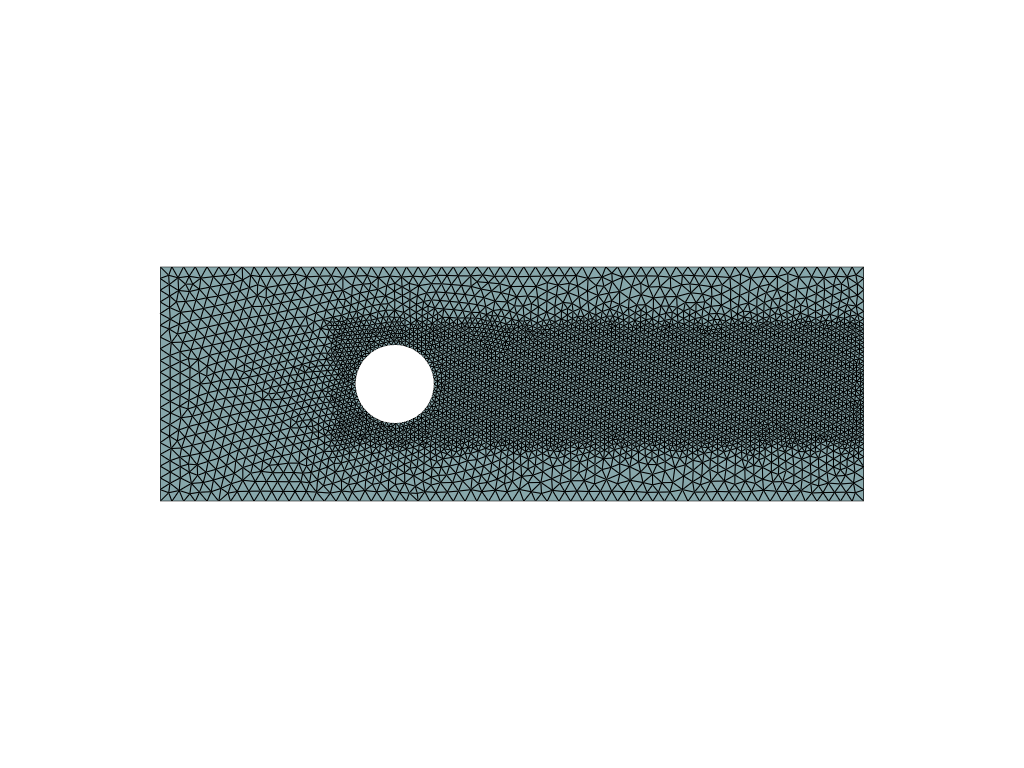

In [11]:
# Cargar el archivo XDMF
rect_ballplot = pv.read('rect_ball.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(rect_ballplot, show_edges=True)
plotter.view_xy()
plotter.show()

Se definen las condiciones de borde y las funciones principales a utilizar en el método de Chorin e IPCS

In [12]:
tapa_arriba = 1
tapa_abajo = 0
tapa_izquierda = 0
tapa_derecha = 3
radio = tapa_arriba/6

def top(x , t=tapa_arriba):
  return np.isclose(x[1],t)

def but(x , t=tapa_abajo):
  return np.isclose(x[1],t)

def left(x , t=tapa_izquierda):
  return np.isclose(x[0],t)

def right(x , t=tapa_derecha):
  return np.isclose(x[0],t)

def bola(x, t =radio):
  return np.isclose((x[0]-tapa_derecha/3)**2+(x[1]-tapa_arriba/2)**2,radio**2)


In [13]:
def solvechorin(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:
    # Tentative velocity step
    U = ufl.TrialFunction(Vspace)
    v = ufl.TestFunction(Vspace)

    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, but)
    bcball_dofs = fem.locate_dofs_geometrical(Vspace, bola)

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs, Vspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(ScalarType((0,0)), bcbut_dofs, Vspace)
    bcball = fem.dirichletbc(ScalarType((0,0)), bcball_dofs, Vspace)

    # Nonlinear term
    F1 = (ufl.inner((U - uprev) / deltat, v) +
          ufl.inner(ufl.dot(ufl.grad(uprev), uprev), v) +
          nu * ufl.inner(ufl.grad(U), ufl.grad(v)) -
          ufl.inner(f, v)) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # Linear problem for tentative velocity
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcbut, bcball,bcleft])
    uh_star = problem1.solve()

    # Pressure correction step
    p = ufl.TrialFunction(Qspace)
    q = ufl.TestFunction(Qspace)
    a2 = ufl.inner(ufl.grad(p), ufl.grad(q)) * ufl.dx
    L2 = - (1 / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx

    # Linear problem for pressure
    problem2 = fem.petsc.LinearProblem(a2, L2)#quite las bc
    ph = problem2.solve()

    # Velocity correction step
    U_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)

    F3 = (ufl.inner(U_, v_)  -
          ufl.inner(uh_star, v_) +
          deltat * ufl.inner(ufl.grad(ph), v_)) * ufl.dx
    a3, L3 = ufl.lhs(F3), ufl.rhs(F3)

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcbut, bcball,bcleft])
    uh = problem3.solve()
    return uh, ph

In [14]:
def solveipcs(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:



    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, but)
    bcball_dofs = fem.locate_dofs_geometrical(Vspace, bola)

    #pout
    bcright_dofs = fem.locate_dofs_geometrical(Qspace, right)
    bcp_outlet = fem.dirichletbc(fem.Constant(domain, ScalarType((0))), bcright_dofs , Qspace)
    bcp = [bcp_outlet]

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs , Vspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(ScalarType((0,0)), bcbut_dofs, Vspace)
    bcball = fem.dirichletbc(ScalarType((0,0)), bcball_dofs, Vspace)


    # Tentative velocity step
    u = ufl.TrialFunction(Vspace)   # velocidad u^*
    v = ufl.TestFunction(Vspace)    # test

    # para la presion
    p = ufl.TrialFunction(Qspace)   # presion a calcular
    q = ufl.TestFunction(Qspace)    # test

    rho = fem.Constant(domain, ScalarType((1)))

    # Paso 1
    F1 = rho/deltat * ufl.dot((u - uprev) , v) * ufl.dx
    # F1 += ufl.inner( ufl.dot( 1.5 * uprev - 0.5 * u ,0.5 * ufl.nabla_grad(u + uprev) ),v ) * ufl.dx     # aqui u debiese ser u^n1
    F1 += ufl.inner( ufl.dot( 1.5 * uprev ,0.5 * ufl.nabla_grad(u + uprev) ),v ) * ufl.dx   # falta el u^n1
    F1 += 0.5 * nu * ufl.inner( ufl.grad(u + uprev) , ufl.grad(v) ) * ufl.dx - ufl.dot(pprev , ufl.div(v)) * ufl.dx   # aqui pprev deberia ser otra cosa creo
    F1 += - ufl.dot(f, v) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # solucionar velocidad tentativa
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcbut, bcball,bcleft])
    uh_star = problem1.solve()


    # Paso 2
    F2 = ufl.inner(ufl.grad(p - pprev), ufl.grad(q)) * ufl.dx
    F2 += (rho / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx
    a2 , L2 = ufl.lhs(F2), ufl.rhs(F2)



    # solucionar presion
    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = bcp) #quite las bc
    ph = problem2.solve()

    # Paso 3
    u_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)



    # solucion velocidad final
    a3 = rho * ufl.dot(u_ , v_) * ufl.dx
    L3 = rho * ufl.dot(uh_star , v_) * ufl.dx - deltat * ufl.dot( ufl.nabla_grad( ph - pprev ) , v ) * ufl.dx

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcbut, bcball,bcleft])
    uh = problem3.solve()
    return uh, ph

Ahora se definen las funciones que realizarán la parte de diferencias finitas de ambos métodos:

In [15]:
def supersolveipcs(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              min_aprox = time_aprox // 60
              print("Tiempo aprox: "+ str(round(min_aprox // 60)) + " horas y " + str(round(min_aprox % 60))+ " minutos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t,1)))
            uh, ph = solveipcs(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

In [16]:
def supersolvechorin(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              min_aprox = time_aprox // 60
              print("Tiempo aprox: "+ str(round(min_aprox // 60)) + " horas y " + str(round(min_aprox % 60))+ " minutos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t,1)))
            uh, ph = solvechorin(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

Se define lo necesario para realizar las simulaciones:

In [17]:
domain = rect_ball

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025 #El paso será de 0.025 segundos.
nu = 0.002 #La viscosidad de 0.002

f = fem.Constant(domain, ScalarType((0,0)))

Finalmente se itera sobre distintos tiempos para obtener cuál método es más rápido computacionalmente, el paso usado.

In [18]:
tiempos_ipcs = []
for t in range(10):
  start_time = time.time()
  uH, pH = supersolveipcs(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,t)
  end_time = time.time()
  ex_time = end_time-start_time
  tiempos_ipcs.append(ex_time)

Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
t: 3.0
Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
Tiempo aprox: 0 horas y 0 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
Tiempo aprox: 0 horas y 1 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
Tiempo aprox: 0 horas y 1 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
t: 8.0
Tiempo aprox: 0 horas y 1 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
t: 8.0
t: 9.0


In [19]:
tiempos_chorin = []
for t in range(10):

  start_time = time.time()
  uH, pH = supersolvechorin(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,t)
  end_time = time.time()
  ex_time = end_time-start_time
  tiempos_chorin.append(ex_time)

Tiempo aprox: 0 horas y 1 minutos.
t: 1.0
Tiempo aprox: 0 horas y 2 minutos.
t: 1.0
t: 2.0
Tiempo aprox: 0 horas y 4 minutos.
t: 1.0
t: 2.0
t: 3.0
Tiempo aprox: 0 horas y 5 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
Tiempo aprox: 0 horas y 6 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
Tiempo aprox: 0 horas y 8 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
Tiempo aprox: 0 horas y 10 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
Tiempo aprox: 0 horas y 11 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
t: 8.0
Tiempo aprox: 0 horas y 12 minutos.
t: 1.0
t: 2.0
t: 3.0
t: 4.0
t: 5.0
t: 6.0
t: 7.0
t: 8.0
t: 9.0


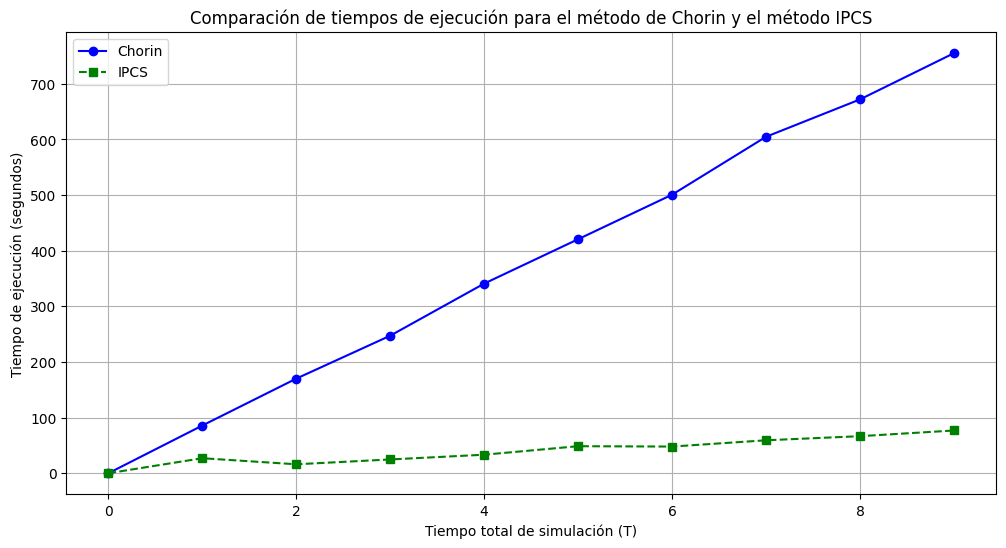

In [20]:
rango = [i for i in range(10)]

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Graficar ambos conjuntos de tiempos de ejecución
plt.plot(rango, tiempos_chorin, marker='o', label='Chorin', linestyle='-', color='blue')
plt.plot(rango, tiempos_ipcs, marker='s', label='IPCS', linestyle='--', color='green')

# Agregar etiquetas y título
plt.xlabel('Tiempo total de simulación (T)')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.title('Comparación de tiempos de ejecución para el método de Chorin y el método IPCS')

# Agregar una leyenda para diferenciar las series
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()

El gráfico final demuestra que el método de Chorin es considerablemente más lento para tiempos pequeños de simulación.